# Makes pie charts of peak distributions
- given a manifest (input norm manifest that the yeolab uses), plots a pie distribution for all rbps

In [98]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [99]:
ipnorm_manifest = pd.read_table('/home/bay001/projects/tbos_clipseq_20160809/analysis/recall_clips/recall_with_old/input_norm/input_norm_manifest.tsv')
uid2rbp = dict(zip(ipnorm_manifest.uID, ipnorm_manifest.RBP))
ipnorm_manifest

,uID,RBP,Cell line,CLIP,INPUT
0,A11_01,BOLL,.,/home/bay001/projects/tbos_clipseq_20160809/an...,/home/bay001/projects/tbos_clipseq_20160809/an...
1,A11_02,BOLL,.,/home/bay001/projects/tbos_clipseq_20160809/an...,/home/bay001/projects/tbos_clipseq_20160809/an...
2,A1_01,DAZAP1,.,/home/bay001/projects/tbos_clipseq_20160809/an...,/home/bay001/projects/tbos_clipseq_20160809/an...
3,A1_02,DAZAP1,.,/home/bay001/projects/tbos_clipseq_20160809/an...,/home/bay001/projects/tbos_clipseq_20160809/an...
4,A2_01,CSTF1,.,/home/bay001/projects/tbos_clipseq_20160809/an...,/home/bay001/projects/tbos_clipseq_20160809/an...
5,A2_02,CSTF1,.,/home/bay001/projects/tbos_clipseq_20160809/an...,/home/bay001/projects/tbos_clipseq_20160809/an...
6,A3_01,CCNL1,.,/home/bay001/projects/tbos_clipseq_20160809/an...,/home/bay001/projects/tbos_clipseq_20160809/an...
7,A3_02,CCNL1,.,/home/bay001/projects/tbos_clipseq_20160809/an...,/home/bay001/projects/tbos_clipseq_20160809/an...
8,A4_01,FUBP1,.,/home/bay001/projects/tbos_clipseq_20160809/an...,/home/bay001/projects/tbos_clipseq_20160809/an...
9,A4_02,FUBP1,.,/home/bay001/projects/tbos_clipseq_20160809/an...,/home/bay001/projects/tbos_clipseq_20160809/an...


In [100]:
l10pv = 5
l2fcv = 3
wd = '/home/bay001/projects/tbos_clipseq_20160809/analysis/recall_clips/recall_with_old/'
input_norm_bed_head = ['chrom','start','end','l10p','l2fc','strand','annotation','gene']
allpeaks = ! ls $wd/*.bed.annotated
allpeaks[:1]


['/home/bay001/projects/tbos_clipseq_20160809/analysis/recall_clips/recall_with_old//A11_01_01.basedon_A11_01_01.peaks.l2inputnormnew.bed.compressed.bed.annotated']

In [101]:
def get_region(row):
    return 'intergenic' if row['annotation'] == 'intergenic' else row['annotation'].split('|')[0]
def get_containment(row):
    return 'intergenic' if row['annotation'] == 'intergenic' else row['annotation'].split('|')[1]

In [102]:
for peak in allpeaks:
    df = pd.read_table(peak,names=input_norm_bed_head)
    name = uid2rbp[re.findall('([\w\d_]+)_[\d].$',os.path.basename(peak).split('.')[0])[0]]
    df['region'] = df.apply(get_region,axis=1)
    df['containment'] = df.apply(get_containment,axis=1)
    dfx = df[(df['l10p'] > l10pv) & (df['l2fc'] > l2fcv)]
    num_peaks = dfx.shape[0]

    regions = dfx['region'].value_counts().to_dict()
    labels = []
    sizes = []

    colors = sns.color_palette("hls", len(regions))

    for region, count in regions.iteritems():
        labels.append(region)
        sizes.append(count)

    """
    Plot pie
    """
    # The slices will be ordered and plotted counter-clockwise.

    plt.pie(sizes, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=90)
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.axis('equal')
    plt.title(name,y=1.1)
    plt.tight_layout()

    plt.savefig(peak.replace('.annotated','.svg'))
    
    plt.close()
    

'A11_01_01.basedon_A11_01_01.peaks.l2inputnormnew.bed.compressed.bed.annotated'

(-1.0204482437884626, 1.0228986217733678, -1.0025140947189684, 1.0)

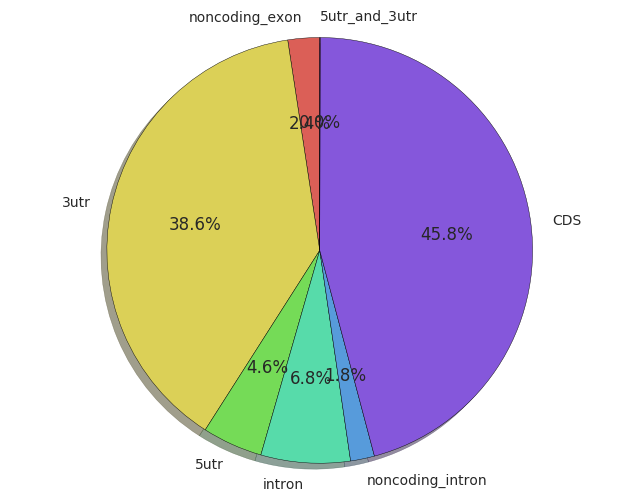